<a href="https://colab.research.google.com/github/WillHBX/PM2.5-forecasting-based-on-attention-based-LSTM-neural-network/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## site
萬華(target)
中山 古亭 永和 板橋 新莊 菜寮 ~~三重~~ ~~大同~~ 松山 士林   
大同少了很多天 (刪掉)  
三重少了時均風速風向 (刪掉)  
新增松山 士林

## Items
| items | ˋ皿ˊ | 
|:--------:|:--------: | 
|TEMP    |  溫度  |
|PM2.5  | 就 PM2.5|
|RAINFALL | 降雨  |
|RH      |  相對溼度  |
|WD_HR  |   時平均風向  |
|WS_HR  |   時平均風速  |

## train_data
(samples, features, time)

## NOTE
空品csv要取代 '\# *', '~* *', 'A *', 'x *', 'NA *'

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/大專生科技部計畫/data/2021/"
fileList = os.listdir(path)
col_name = ['site', 'date', 'items']
items_name = ['AMB_TEMP', 'PM2.5', 'RAINFALL', 'RH', 'WS_HR', 'WD_HR']
site_name = ['萬華', '中山', '古亭', '永和', '板橋', '新莊', '菜寮', '松山', '士林']
# s_to_eng = {'萬華': 'WanHua', '中山': 'ZhongShan', '古亭': 'GuTing ',
#             '永和': 'YongHe ', '板橋':'BanQiao', '新莊': 'XinZhuang', '菜寮': , '松山': 'SongShan', '士林': 'ShiLin'}
site_df = []

for i in range(24):
  col_name.append(str(i))
for file in fileList:
  data = pd.read_csv(path+file, encoding='unicode_escape', names = col_name, header = None)
  # data1 = pd.read_csv(path+file, encoding='big5')#, names = col_name, header = None)
  data.drop([0,1], inplace = True)                        
  data = data.reset_index(drop = True)
  data['site'] = file[0:2]                # insert site name
  data['items'] = [it.strip() for it in   data['items']]  # delete spaces in 'items'
  data = data[data['items'].isin(items_name)]             # drop useless items


  site_df.append(data)

In [ ]:
time_series = dict()
idx_to_item = {}
site_items_timeSeries = dict(list())
# tmp = [ site, date, columns ]
for s in site_df:
  for idx, it in enumerate(items_name):
    idx_to_item[idx] = it
    all_time = []
    # print(s['site'])
    for id, row in s[s['items'] == it].iterrows():
      all_time.extend([float(i) for i in row[3:]])
    # if s['site'].iloc[0] == '新莊': 
      # print(it,all_time)
    if s['site'].iloc[0] not in site_items_timeSeries.keys():
      site_items_timeSeries[s['site'].iloc[0]] = []
    site_items_timeSeries[s['site'].iloc[0]].append(all_time)
    # print(idx)
  # print(s['site'].iloc[0])
  time_series[s['site'].iloc[0]] = pd.DataFrame(np.array(site_items_timeSeries[s['site'].iloc[0]]).T.tolist(), columns = items_name)
# time_series 
#############################################################
# time_seriess[site] to get values of all items of the year #
#############################################################


# Wind Direction
|degree|direction|
|:----:|:------:|
|22.5 ~ 67.5|EN|
|67.5 ~ 112.5|E|
|112.5 ~ 157.5|ES|
|157.5 ~ 202.5|S|
|202.5 ~ 247.5|WS|
|247.5 ~ 292.5|W|
|292.5 ~ 337.5|WN|
|337.5 ~ 360 or 0 ~22.5|N|


In [ ]:
direction = ['EN', 'E', 'ES', 'S', 'WS', 'W', 'WN', 'N']

def fill_missing_value(df,it):
  # result = df.copy()
  start = -1
  # d means degree
  for i, num in enumerate(df):
    if np.isnan(num) or (num>100 and it!='WD_HR'):
      if start == -1:
        start = i
    else:
      # df[i] = direction[int(num/45-0.5)%8]
      if start != -1:
        for idx in range(start, i):
          
          fill_value =  df[start-1] + (df[i]-df[start-1]) / (i-start+1)*(idx-start+1)

          df[idx] = fill_value
        start = -1
  if start != -1:
      for idx in range(start, i):
          
        fill_value =  df[start-1] + (df[i]-df[start-1]) / (i-start+1)*(idx-start+1)

        df[idx] = fill_value

  return df


def deg_to_dir(d):
  return direction[int( d / 45 - 0.5) % 8]



# Fill missing value  
# One-hot encoding
# Normalization

In [ ]:
from sklearn import preprocessing

zscore = preprocessing.StandardScaler()

for k in time_series.keys():
  for it in items_name:
    # fill missing value
    # print(it)
    time_series[k][it] = fill_missing_value(time_series[k][it],it)
    
    if it == 'WD_HR':
      # change wind degree to direction
      time_series[k][it] = [deg_to_dir(d) for d in time_series[k][it]]
    # else:
    #   # normalization
    #   arr = np.array(time_series[k][it]).reshape(-1,1)
    #   time_series[k][it] = zscore.fit_transform(arr)
    
    # one-hot encoding
    time_series[k] = pd.get_dummies(time_series[k])
    

for s in site_name:
  for d in direction:
    time_series[s]['WD_HR_'+d] = time_series[s]['WS_HR']*time_series[s]['WD_HR_'+d]
    


In [ ]:
time_series['古亭']

,AMB_TEMP,PM2.5,RAINFALL,RH,WS_HR,WD_HR_E,WD_HR_EN,WD_HR_ES,WD_HR_N,WD_HR_S,WD_HR_W,WD_HR_WN,WD_HR_WS
0,10.6,15.0,0.0,67.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10.6,15.0,0.0,67.0,0.8,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0
2,10.6,8.0,0.0,68.0,0.9,0.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0
3,10.6,13.0,0.0,68.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10.7,14.0,0.0,68.0,0.7,0.0,0.0,0.7,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,15.4,9.0,0.0,84.0,1.6,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,15.3,11.0,0.0,89.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,15.3,13.0,0.0,90.0,0.9,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,15.2,9.0,0.0,94.0,1.1,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Store data
rain -> [ rainfall...] ( time, 1+8 )   
wind -> [ WD...　] ( time, 8 )  
pm25 -> [　pm25_loc...　] ( time, 1+8 )  
target -> [　target location pm25 after n hours　] ( time, 1 )  


In [ ]:
# PM2.5 data ( other locations )

df = pd.DataFrame()
for s in site_name:
  df = pd.concat([df,time_series[s]['PM2.5']], axis = 1)

df.columns = site_name
np.savez('/content/drive/MyDrive/大專生科技部計畫/data/samples/'+'2018_pm25_data.npz', data = df)
df

,萬華,中山,古亭,永和,板橋,新莊,菜寮,松山,士林
0,18.0,12.0,12.0,17.0,20.0,15.0,16.0,25.0,16.0
1,21.0,19.0,12.0,19.0,19.0,14.0,19.0,15.0,19.0
2,17.0,18.0,9.0,17.0,17.0,11.0,19.0,23.0,14.0
3,17.0,14.0,10.0,16.0,17.0,14.0,17.0,18.0,17.0
4,10.0,9.0,9.0,18.0,16.0,14.0,15.0,25.0,12.0
...,...,...,...,...,...,...,...,...,...
8755,4.0,13.0,7.0,3.0,6.0,1.0,2.0,3.0,6.0
8756,2.0,10.0,7.0,5.0,9.0,1.0,3.0,6.0,1.0
8757,7.0,11.0,7.0,6.0,10.0,4.0,1.0,1.0,1.0
8758,4.0,8.0,5.0,3.0,4.0,1.0,1.0,2.0,3.0


In [ ]:
# 目標地點的 風向時間序列 
pm25 = time_series[s]['PM2.5']
wind = time_series['萬華'].iloc[:,5:]
# wind_data = pd.concat([pm25 , wind], axis = 1) 
np.savez('/content/drive/MyDrive/大專生科技部計畫/data/samples/'+'2018_target_wind_data.npz', data = wind)
wind


,WD_HR_E,WD_HR_EN,WD_HR_ES,WD_HR_N,WD_HR_S,WD_HR_W,WD_HR_WN,WD_HR_WS
0,2.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8755,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
rain = pd.DataFrame()
for s in site_name:
  rain = pd.concat([rain,time_series[s]['RAINFALL']], axis = 1)

rain.columns = site_name
np.savez('/content/drive/MyDrive/大專生科技部計畫/data/samples/'+'2021_rain_data.npz', data = rain)
rain

,萬華,中山,古亭,永和,板橋,新莊,菜寮,松山,士林
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
8755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


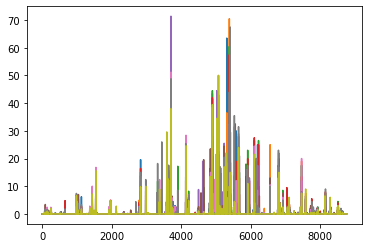

In [ ]:
import matplotlib.pyplot as plt
n = 1244
plt.plot(rain)

In [ ]:
# target6 = wind_data['PM2.5'][6:]
# target12 = wind_data['PM2.5'][12:]
# target24 = wind_data['PM2.5'][24:]

# np.savez('/content/drive/MyDrive/大專生科技部計畫/data/samples/'+'2018_target6.npz', data = target6)
# np.savez('/content/drive/MyDrive/大專生科技部計畫/data/samples/'+'2018_target12.npz', data = target12)
# np.savez('/content/drive/MyDrive/大專生科技部計畫/data/samples/'+'2018_target24.npz', data = target24)

In [ ]:
target6 = wind_data['PM2.5'][6:]
target6

6       25.0
7       21.0
8       21.0
9       21.0
10      23.0
        ... 
8755     6.0
8756     1.0
8757     1.0
8758     3.0
8759     3.0
Name: PM2.5, Length: 8754, dtype: float64

In [ ]:
_# 以下先不用

In [ ]:
# for s in site_name:
#   data = time_series[s]
#   # use 6-hr historical data to predict PM2.5 value during the next 1 hr 
#   data_set = np.array([data[i:i+7] for i in range(len(data)-7)])
#   np.savez('/content/drive/MyDrive/大專生科技部計畫/data/samples/'+s+'_7hr_data.npz', data = data_set)



In [ ]:

# np.save('/content/drive/MyDrive/大專生科技部計畫/data/samples/items_name', items_name)
# np.save('/content/drive/MyDrive/大專生科技部計畫/data/samples/site_name', site_name)


In [ ]:
#####################################
# missing value     (o)
# one-hot encoding  (o)
# normalization     (o)
# sliding window    (o)
#####################################

#####################################
# PM2.5 vector: (timestep, location)
# wind vector:  only target location
# split train/test set ???
# QAQ
#####################################